## Import thư viện

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import warnings
import os
import cv2

In [80]:
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Đọc dữ liệu

### Dữ liệu huấn luyện

In [4]:
# path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset" # đường dẫn đến thư mục chứa dữ liệu
classes = [i for i in os.listdir(path) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [5]:
data = [] # mảng chứa dữ liệu
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

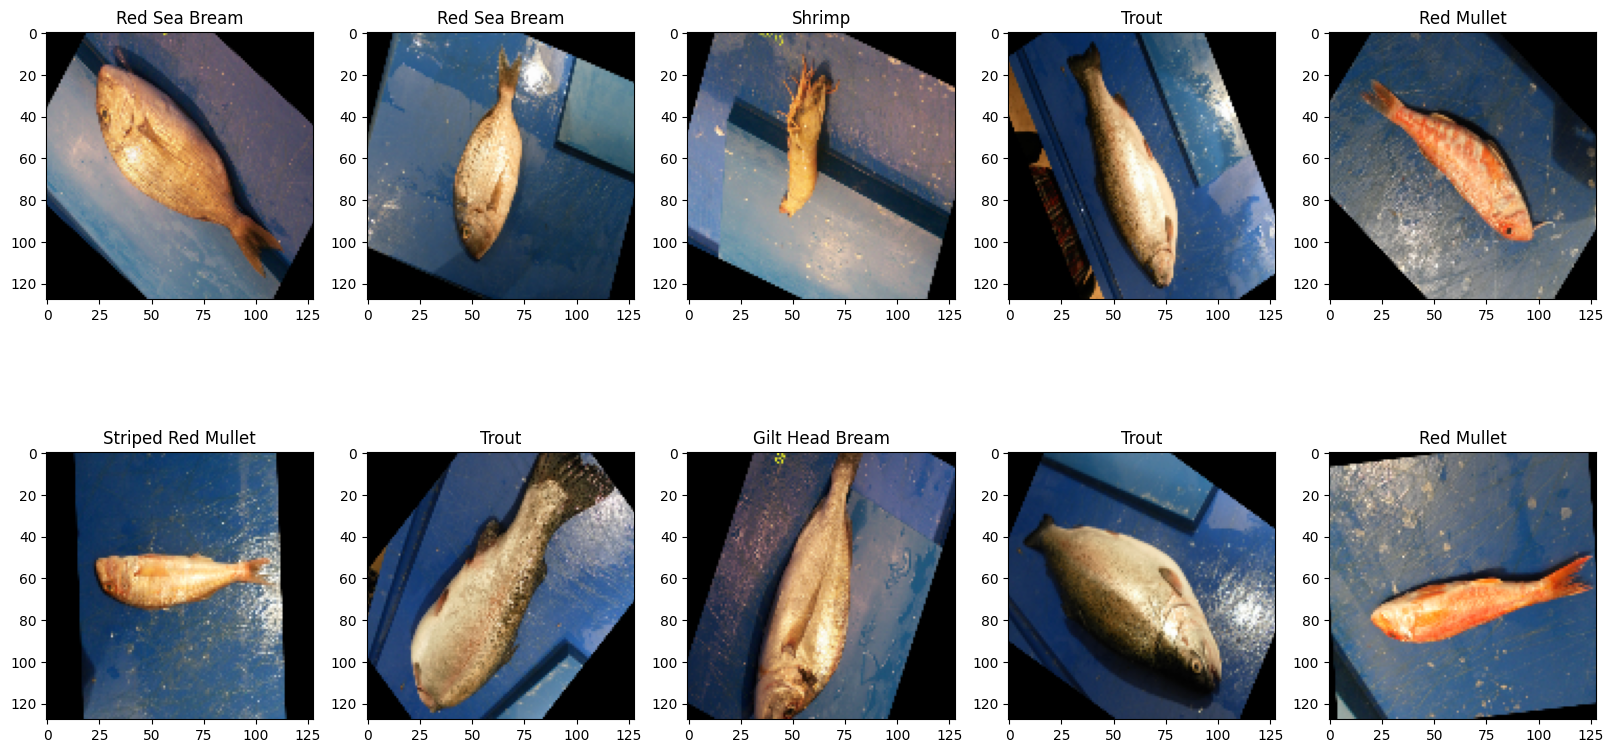

In [6]:
# hiện thị một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [7]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [8]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [9]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [10]:
# duỗi ảnh thành vector
images = images.reshape(images.shape[0], -1) # 9000 ảnh, mỗi ảnh có 128x128x3 = 49,152 pixel

#### Chia dữ liệu Train và Validation

In [12]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((7200, 49152), (1800, 49152), (7200,), (1800,))

In [13]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800}

### Dữ liệu kiểm tra (Test)

In [14]:
data_test = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [15]:
# shuffle data_test
import random
random.shuffle(data_test)

In [16]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [17]:
# chuấn hóa label
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [18]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(430, 128, 128, 3)

In [19]:
# duỗi ảnh thành vector
test_images = test_images.reshape(test_images.shape[0], -1) # 9000 ảnh, mỗi ảnh có 128x128x3 = 49,152 pixel

## Xây dựng model

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

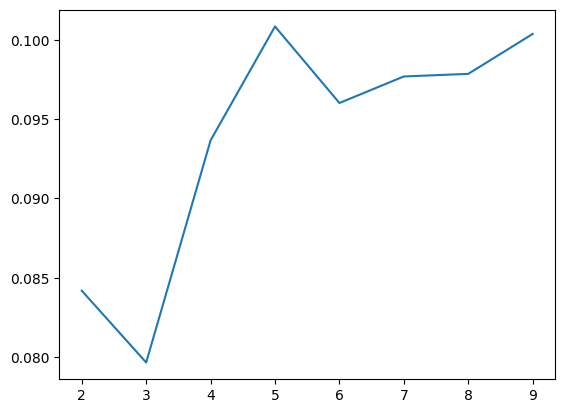

In [81]:
# sử dụng Elbow method để tìm số lượng cluster phù hợp
scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(train_images)
    scores.append(silhouette_score(train_images, kmeans.labels_))

plt.plot(range(2, 10), scores)

In [82]:
# in ra số k và silhouette score tương ứng
for i in range(2, 10):
    print(i, scores[i-2])

2 0.08418367
3 0.07965966
4 0.09366144
5 0.1008393
6 0.096016355
7 0.09768905
8 0.097852156
9 0.10036865


In [76]:
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
clusters = kmeans.fit_predict(train_images)
kmeans.cluster_centers_.shape

(9, 49152)

In [77]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(9):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[36, 12, 4, 9, 10, 0, 3, 1, 23]

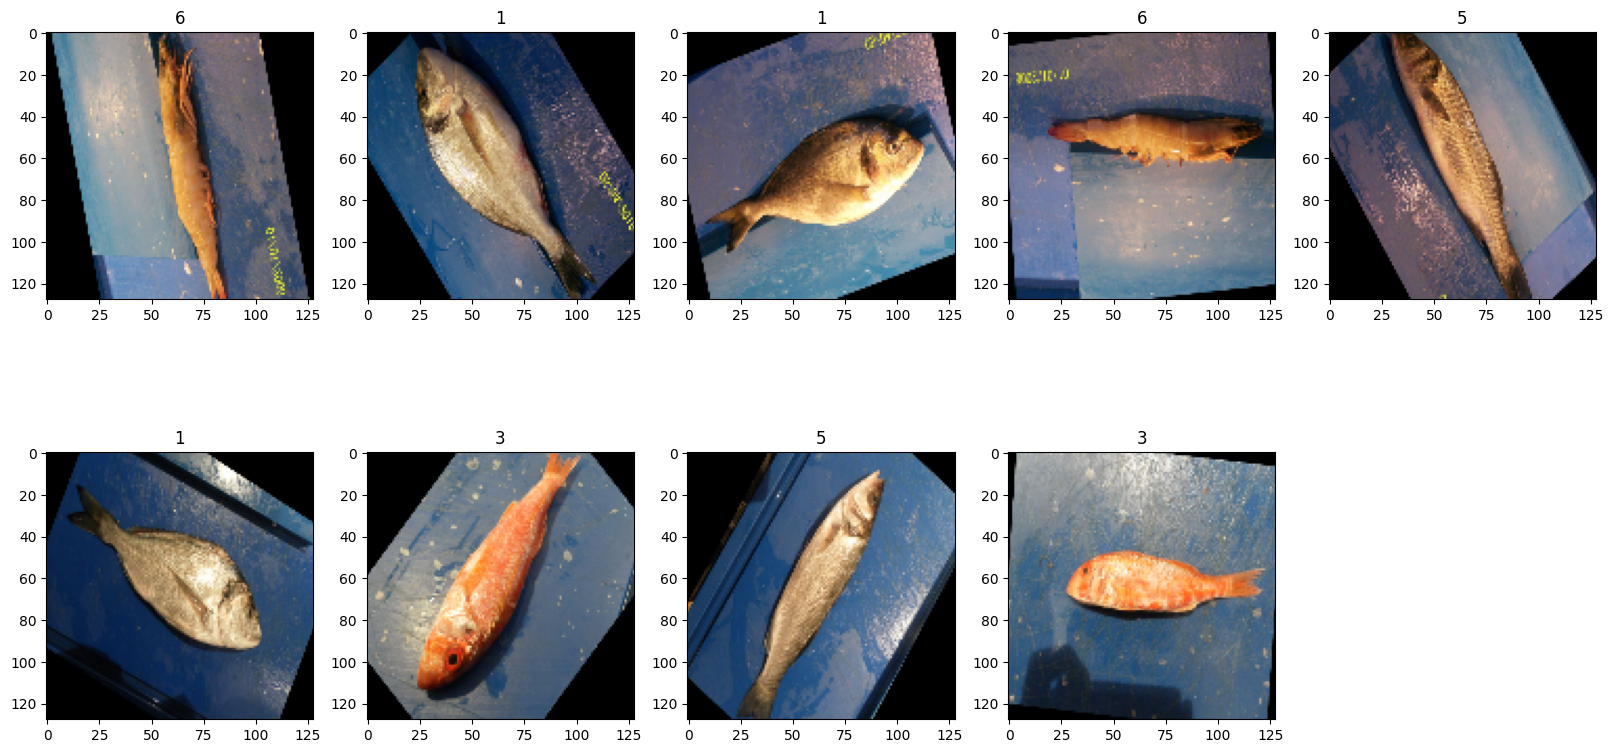

In [78]:
# hiện thị các ảnh là tâm của các cluster
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[center_id[i]].reshape(128, 128, 3))
    # plt.title(i)
    plt.title(train_labels[center_id[i]])

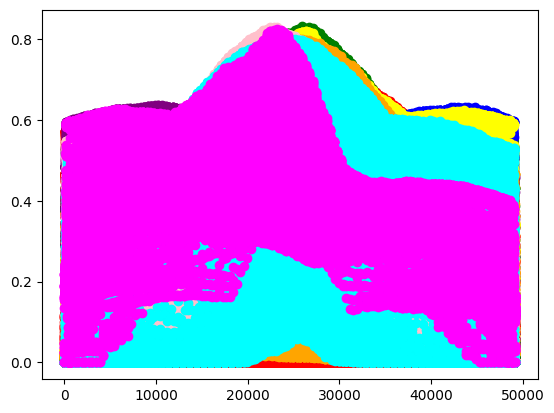

In [27]:
x_data = [i for i in range(49152)]
colors = ['red','green','blue','yellow','purple','orange','pink','cyan','magenta']
for i in range(9):
    plt.scatter(x_data,kmeans.cluster_centers_[i], color = colors[i])